In [1]:
# import tensorflow as tf
# from tensorflow import keras
from sklearn.svm import LinearSVC
from sklearn import feature_extraction, model_selection, metrics
import numpy as np
import string
import gensim

C:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import math
import collections
from nltk.corpus import stopwords

In [4]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import networkx as nx
import spacy
nlp = spacy.load('en_core_web_sm')

In [5]:
#Enable eager execution since this code is experimental
# tf.enable_eager_execution()
# tfe = tf.contrib.eager

In [6]:
table = str.maketrans('', '', '!"#$%&\'()*+,-.:;<=>?@[\\]^_`{|}~' + "0123456789")
table2 = str.maketrans('/', ' ')
stopWords = set(stopwords.words('english'))
dataset = []
sentences = []
maxSentLen = 0
avgSentLen = 0
missingVectors = {}

In [7]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
# with open('stopwords.txt') as file:
#     for line in file:
#         line = line.lower()
#         stopWords.append(line.strip())

In [9]:
def preprocess(text, aspectTerm=None, flag=None):
    text = text.replace("[comma]", "")
    text = text.replace("  ", " ")
    text = text.replace('"', '').replace('.','').replace('(',' ').replace('(','').replace(')','').replace('!','').replace("?",'').replace("  "," ")
    text = text.lstrip('- ')
    text = text.lstrip('_')    
    text = text.lstrip('_ ')
    text = text.lstrip('-')
    text = text.rstrip(' ')
    text = text.translate(table2)
    gw = lambda w: w.lower() if w.lower() in aspectTerm else w.translate(table).lower()
    if flag:
        x = aspectTerm.replace(" ","_")
        text = text.replace(aspectTerm,x)
        temp = text.split()
        try:
            atPos = temp.index(x)
        except ValueError:
            xx = x[0].replace("_", "")
            for w in temp:
                if x in w:
                    x = w
                    atPos = temp.index(x)
                    break
                if xx in w:
                    xx = w
                    atPos = temp.index(xx)
        return [text, x+'-'+str(atPos)]
    elif aspectTerm:
        text = [gw(word) for word in text.split() 
                if len(word) > 1 and (word.lower() in aspectTerm or word.translate(table).lower() not in stopWords)]
    else:
        text = [word.lower() for word in text.translate(table2).split() if len(word) > 1]
    return text

In [10]:
# should $numbers be removed ?

In [11]:
length = 0
ll = []
with open('data-2_train.csv') as file:
    file.readline()
    for line in file:
        data = line.split(",")
        data[2] = preprocess(data[2])
        data[1] = preprocess(data[1], data[2])
        sentences.append(preprocess(' '.join(data[1]), ' '.join(data[2]), True))
        data[-1] = data[-1].strip()
        length += len(data[1])
        ll.append(len(data[1]))
        if len(data[1]) > maxSentLen:
            maxSentLen = len(data[1])
        dataset.append(data)
avgSentLen = length / len(dataset)

In [12]:
print(maxSentLen, avgSentLen)
print(sorted(ll)[int(len(ll)/2)])

36 9.352026651860077
8


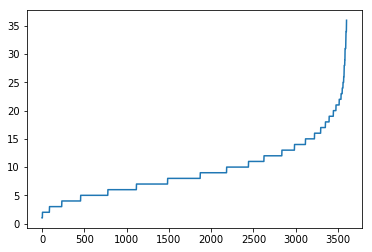

In [13]:
plt.plot(range(len(ll)), sorted(ll))
plt.show()

In [14]:
maxSentLen = 20

In [15]:
weD = 300
wvD = weD

In [16]:
# def train(data, label):
#     clf=LinearSVC(multi_class='crammer_singer',random_state=0)
    
#     preds = model_selection.cross_val_predict(clf, data, label, cv=10)
#     accScore = metrics.accuracy_score(label,preds)
#     labels = [-1, 0, 1]
#     precision = metrics.precision_score(label,preds,average=None,labels=labels)
#     recall = metrics.recall_score(label,preds,average=None,labels=labels)
#     f1Score = metrics.f1_score(label,preds,average=None,labels=labels)
#     print("\nOverall Acurracy - SVM: ",accScore,"\n")
#     for i in range(len(labels)):
#         print("Precision of %s class: %f" %(labels[i],precision[i]))
#         print("Recall of %s class: %f" %(labels[i],recall[i]))
#         print("F1-Score of %s class: %f" %(labels[i],f1Score[i]),"\n")

In [17]:
def getSentGraph(sent):
    document = nlp(sent)

    # Load spacy's dependency tree into a networkx graph
    edges = []
    for token in document:
        # FYI https://spacy.io/docs/api/token
        for child in token.children:
            edges.append(('{0}-{1}'.format(token.lower_,token.i),
                          '{0}-{1}'.format(child.lower_,child.i)))

    return nx.Graph(edges)

In [18]:
X1 = []
y = []
yForSk = []
flag = "input"

In [19]:
for i, data in enumerate(dataset):
    data1 = []
    meanAspVec = None
    
    #print(i)
    graph = getSentGraph(sentences[i][0])
    
    #if more than one word in aspect term, take mean
    mean = np.zeros((weD, 1))
    for w in data[2]:
        twv = None
        try:
            if w in missingVectors:
                twv = missingVectors[w]
            else:
                twv = word2vec[w].reshape(weD, 1)
        except KeyError:
            twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
            missingVectors[w] = twv
        mean += twv
    meanAspVec = mean/len(data[2])
    
    E = []
    
#     for wv in data1:
#         E.append(np.dot(wv.T, meanAspVec)/(np.linalg.norm(wv)) * np.linalg.norm(meanAspVec))
    
#     E = np.array(E).reshape(300, 1)
#     A = np.exp(E) / np.sum(np.exp(E))

    for w in data[1]:
        twv = None
        try:
            if w in missingVectors:
                twv = missingVectors[w]
            else:
                twv = word2vec[w].reshape(weD, 1)
        except KeyError:
            twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
            missingVectors[w] = twv
        E.append(np.dot(twv.T, meanAspVec) / (np.linalg.norm(twv) * np.linalg.norm(meanAspVec)))

    A = np.exp(E) / np.sum(np.exp(E)) # softmax
    
    tttemp = sentences[i][0].split()
    distVec = []
    for jj, w in enumerate(data[1]):
        if w in sentences[i][1]:
            dist = 1
        else:
            try:
                dist = 1/nx.shortest_path_length(graph, source=sentences[i][1], target=w+'-'+str(tttemp.index(w)))
            except (nx.NetworkXNoPath, KeyError, nx.NetworkXError):
                dist = 1/maxSentLen
        distVec.append(dist)
        twv = None
        if w in missingVectors:
            twv = missingVectors[w]
        else:
            twv = word2vec[w].reshape(weD, 1)
        if flag == "attention":
            data1.append(A[jj] * twv)
        elif flag == "input":
            data1.append(twv)

#     for w in data[1]:
#         twv = None
#         try:
#             if w in missingVectors:
#                 twv = missingVectors[w]
#             else:
#                 twv = word2vec[w].reshape(300, 1)
#         except KeyError:
#             twv = np.random.normal(size=(300, 1))/math.sqrt(301)
#             missingVectors[w] = twv
            
#         data1.append(np.vstack((twv, meanAspVec)))
    
    if len(data1) < maxSentLen:
        j = len(data1) + 1
        while j <= maxSentLen:
            #data1.append(np.vstack((word2vec['#'].reshape(300, 1), meanAspVec)))
            #data1.append(np.vstack((np.zeros((300, 1)), meanAspVec)))
            data1.append(np.zeros((wvD, 1)))
            distVec.append(0.0)
            j += 1
    
    if len(data1) > maxSentLen:
        del data1[maxSentLen:]
        del distVec[maxSentLen:]
    
    protoVec = np.array([np.mean(data1, axis=0)]).reshape(300,)
    protoVec = np.append(protoVec, distVec)
    X1.append(protoVec)
    yForSk.append(data[-1])
    if data[-1] == '-1':
        y.append(np.array([[0.0, 0.0, 1.0]]))
    elif data[-1] == '0':
        y.append(np.array([[0.0, 1.0, 0.0]]))
    elif data[-1] == '1':
        y.append(np.array([[1.0, 0.0, 0.0]]))

X1 = np.array(X1)
y = np.array(y)
yForSk = np.array(yForSk)

In [20]:
sentences[26]

['pizza best like thin_crusted_pizza', 'thin_crusted_pizza-3']

In [21]:
X1.shape

(3602, 320)

In [22]:
y.shape

(3602, 1, 3)

In [23]:
list(yForSk[[0, 1, 2]])

['-1', '1', '1']

In [24]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

In [25]:
#train(X1, yForSk)


In [26]:
accuracies = []
precisions = []
recalls = []
f1s = []

for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
    print("Fold -", index)
    xtrain, xtest = X1[train_ind], X1[test_ind]
    ytrain, ytest = list(yForSk[train_ind]), list(yForSk[test_ind])
    
    clf=LinearSVC(multi_class='crammer_singer',random_state=0)
    #print(X_train.toarray())
    clf.fit(xtrain, ytrain)
    #print(log_reg.score(X_train, y_train))
    #print(log_reg.score(X_test, y_test))
    ypred = clf.predict(xtest)
    acc = np.mean(ytest == ypred)
    conf_matrix = confusion_matrix(ytest, ypred)
    print(conf_matrix)
    #print(X_train.shape, X_train.shape)
    print(precision_recall_fscore_support(ytest, ypred))
    stats = precision_recall_fscore_support(ytest, ypred, labels=[-1, 0, 1])
    
    p = np.array([stats[0][2], stats[0][1], stats[0][0]])
    r = np.array([stats[1][2], stats[1][1], stats[1][0]])
    f = np.array([stats[2][2], stats[2][1], stats[2][0]])
    
    accuracies.append(acc)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)
    
    print("accuracy=", acc, "precision=", p, "recall=", r, "F1 Score=", f)

Fold - 0


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 39   3  39]
 [ 15  13  36]
 [  7   3 207]]
(array([ 0.63934426,  0.68421053,  0.73404255]), array([ 0.48148148,  0.203125  ,  0.95391705]), array([ 0.54929577,  0.31325301,  0.82965932]), array([ 81,  64, 217], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.71546961326 precision= [ 0.73404255  0.68421053  0.63934426] recall= [ 0.95391705  0.203125    0.48148148] F1 Score= [ 0.82965932  0.31325301  0.54929577]
Fold - 1


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 44   9  28]
 [ 11  10  43]
 [ 14   5 198]]
(array([ 0.63768116,  0.41666667,  0.73605948]), array([ 0.54320988,  0.15625   ,  0.9124424 ]), array([ 0.58666667,  0.22727273,  0.81481481]), array([ 81,  64, 217], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.696132596685 precision= [ 0.73605948  0.41666667  0.63768116] recall= [ 0.9124424   0.15625     0.54320988] F1 Score= [ 0.81481481  0.22727273  0.58666667]
Fold - 2


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 30   4  47]
 [ 15  12  37]
 [ 12   1 204]]
(array([ 0.52631579,  0.70588235,  0.70833333]), array([ 0.37037037,  0.1875    ,  0.94009217]), array([ 0.43478261,  0.2962963 ,  0.80792079]), array([ 81,  64, 217], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.67955801105 precision= [ 0.70833333  0.70588235  0.52631579] recall= [ 0.94009217  0.1875      0.37037037] F1 Score= [ 0.80792079  0.2962963   0.43478261]
Fold - 3


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 43   6  32]
 [ 14   9  40]
 [  6   2 209]]
(array([ 0.68253968,  0.52941176,  0.74377224]), array([ 0.5308642 ,  0.14285714,  0.96313364]), array([ 0.59722222,  0.225     ,  0.83935743]), array([ 81,  63, 217], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.722991689751 precision= [ 0.74377224  0.52941176  0.68253968] recall= [ 0.96313364  0.14285714  0.5308642 ] F1 Score= [ 0.83935743  0.225       0.59722222]
Fold - 4


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 48   6  27]
 [ 16   7  40]
 [ 12   1 203]]
(array([ 0.63157895,  0.5       ,  0.75185185]), array([ 0.59259259,  0.11111111,  0.93981481]), array([ 0.61146497,  0.18181818,  0.83539095]), array([ 81,  63, 216], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.716666666667 precision= [ 0.75185185  0.5         0.63157895] recall= [ 0.93981481  0.11111111  0.59259259] F1 Score= [ 0.83539095  0.18181818  0.61146497]
Fold - 5


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 36   3  41]
 [ 20  11  32]
 [ 15   4 197]]
(array([ 0.50704225,  0.61111111,  0.72962963]), array([ 0.45      ,  0.17460317,  0.91203704]), array([ 0.47682119,  0.27160494,  0.81069959]), array([ 80,  63, 216], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.679665738162 precision= [ 0.72962963  0.61111111  0.50704225] recall= [ 0.91203704  0.17460317  0.45      ] F1 Score= [ 0.81069959  0.27160494  0.47682119]
Fold - 6


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 45   3  32]
 [ 18  12  33]
 [  9   1 206]]
(array([ 0.625    ,  0.75     ,  0.7601476]), array([ 0.5625    ,  0.19047619,  0.9537037 ]), array([ 0.59210526,  0.30379747,  0.84599589]), array([ 80,  63, 216], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.732590529248 precision= [ 0.7601476  0.75       0.625    ] recall= [ 0.9537037   0.19047619  0.5625    ] F1 Score= [ 0.84599589  0.30379747  0.59210526]
Fold - 7


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 36   5  39]
 [ 14  11  38]
 [ 11   1 204]]
(array([ 0.59016393,  0.64705882,  0.72597865]), array([ 0.45      ,  0.17460317,  0.94444444]), array([ 0.5106383 ,  0.275     ,  0.82092555]), array([ 80,  63, 216], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.699164345404 precision= [ 0.72597865  0.64705882  0.59016393] recall= [ 0.94444444  0.17460317  0.45      ] F1 Score= [ 0.82092555  0.275       0.5106383 ]
Fold - 8


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 32   8  40]
 [ 12  12  39]
 [  9   1 206]]
(array([ 0.60377358,  0.57142857,  0.72280702]), array([ 0.4       ,  0.19047619,  0.9537037 ]), array([ 0.48120301,  0.28571429,  0.82235529]), array([ 80,  63, 216], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.696378830084 precision= [ 0.72280702  0.57142857  0.60377358] recall= [ 0.9537037   0.19047619  0.4       ] F1 Score= [ 0.82235529  0.28571429  0.48120301]
Fold - 9


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[ 38   6  36]
 [ 15  11  37]
 [  4   6 206]]
(array([ 0.66666667,  0.47826087,  0.73835125]), array([ 0.475     ,  0.17460317,  0.9537037 ]), array([ 0.55474453,  0.25581395,  0.83232323]), array([ 80,  63, 216], dtype=int64))


C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


accuracy= 0.710306406685 precision= [ 0.73835125  0.47826087  0.66666667] recall= [ 0.9537037   0.17460317  0.475     ] F1 Score= [ 0.83232323  0.25581395  0.55474453]


In [27]:
# accuracies = []
# precisions = []
# recalls = []
# f1s = []

# for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
#     print("Fold -", index)
#     xtrain, xtest = X1[train_ind], X1[test_ind]
#     ytrain, ytest = y[train_ind], y[test_ind]
    
#     model = train(xtrain, ytrain)
    
#     predictions = model.predict(xtest)
    
#     y_pred = tf.argmax(predictions, dimension=1)
#     y_test = tf.argmax(ytest.reshape(len(ytest), 3), dimension=1)
    
#     print("Labels=", np.unique(y_test, return_counts=True))
#     print("Predictions=", np.unique(y_pred, return_counts=True))
    
#     cm = confusion_matrix(y_test, y_pred)
#     numer = np.diag(cm)
#     numer = numer.astype(np.float64)
#     deno = np.sum(cm, axis = 1, dtype=np.float64)
#     recall = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
#     deno = np.sum(cm, axis = 0, dtype=np.float64)
#     precision = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
#     #loss, acc = model.evaluate(xtest, ytest)
#     nnum = (precision*recall)
#     ddeno = (precision+recall)
#     f1 = 2*np.divide(nnum, ddeno, out=np.zeros_like(nnum), where=ddeno!=0)
#     acc = np.sum(numer)/np.sum(deno)
    
#     accuracies.append(acc)
#     precisions.append(precision)
#     recalls.append(recall)
#     f1s.append(f1)
#     print("accuracy=", acc, "precision=", precision, "recall=", recall, "F1 Score=", f1)


In [28]:
print("Average Scores:")
print("Avg. accuracy=", np.sum(accuracies)/len(accuracies))
print("Avg. precision=", np.sum(precisions, axis=0)/len(precisions))
print("Avg. recall=", np.sum(recalls, axis=0)/len(recalls))
print("Avg. f1=", np.sum(f1s, axis=0)/len(f1s))

Average Scores:
Avg. accuracy= 0.704892442699
Avg. precision= [ 0.73509736  0.58940307  0.61101063]
Avg. recall= [ 0.94269927  0.17056052  0.48560185]
Avg. f1= [ 0.82594429  0.26355709  0.53949445]


In [29]:
#word2vec['#']#.reshape(300, 1) #numpy array
#print(word2vec.similarity('computer', 'laptop'))
#np.zeros(300).shape
#word2vec.distances(word2vec['computer'], other_words=["laptop"])
#np.append(word2vec["###GB"], np.array([1.0]))
#"accordingly" in stopWords

In [30]:
# def tteest(text, aspectTerm):
#     aspectTerm = aspectTerm.replace("[comma]", "").replace("  ", " ").lower()
#     text = text.lower()
#     x = aspectTerm.replace(" ","_")
#     text = text.replace('"', '').replace('.','').replace('(',' ').replace('(','').replace(')','').replace('!','').replace("?",'').replace("  "," ").replace(aspectTerm,x)
#     text = text.lstrip('- ')
#     text = text.lstrip('_')    
#     text = text.lstrip('_ ')
#     text = text.lstrip('-')
#     text = text.rstrip(' ')
#     atPos = text.split().index(x)
#     return [text, x+'-'+str(atPos)]


# tteest("I also enjoy the fact that my MacBook Pro laptop allows me to run Windows 7 on it by using the VMWare program.","VMWare program")



In [31]:
# oma = []
# def chamma(line):
#     data = line.split(",")
#     data[2] = preprocess(data[2])
#     #print(data[2][0].replace("_", ""))
#     print(data[2])
#     data[1] = preprocess(data[1], data[2])
#     print(data[1])
#     oma.append(preprocess(' '.join(data[1]), ' '.join(data[2]), True))

# chamma("1805_1,Good for every day computing and web browsing.,every day computing,9--28,1")

In [32]:
# oma[0]